In [1]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

1. Перших 2 байти завжди порожні тому ми їх пропускаємо зчитуючи >H тип unsigned short який займає 2 байти

2. 3-ій байт вказує на тип даних
  * 0x08: unsigned byte 
  * 0x09: signed byte 
  * 0x0B: short (2 bytes) 
  * 0x0C: int (4 bytes) 
  * 0x0D: float (4 bytes) 
  * 0x0E: double (8 bytes)
  
3. Наступний байт вказує кількість вимірів матриці

4. Далі послідовно для кожного виміру вказано його розмір як 4-байтове ціле число. Тобто, починаючи з п’ятого байту, три групи по 4 байти вказують на розмірність тривимірної матриці, а саме

In [2]:
print('Labels shape')

with gzip.open('dataset/train-labels-idx1-ubyte.gz', 'rb') as f:
    print(struct.unpack('>HBB', f.read(4)))
    print(struct.unpack('>I', f.read(4)))

print('\nImages shape')
with gzip.open('dataset/train-images-idx3-ubyte.gz', 'rb') as f:
    print(struct.unpack('>HBB', f.read(4)))
    print(struct.unpack('>III', f.read(12)))
    
    

Labels shape
(0, 8, 1)
(60000,)

Images shape
(0, 8, 3)
(60000, 28, 28)


In [3]:
# script for reading MNIST file format
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [4]:
raw_train = read_idx('dataset/train-images-idx3-ubyte.gz')
X_train = raw_train.reshape(60000, 28 * 28)
y_train = read_idx('dataset/train-labels-idx1-ubyte.gz')

raw_test = read_idx('dataset/t10k-images-idx3-ubyte.gz')
X_test = raw_test.reshape(10000, 28 * 28)
y_test = read_idx('dataset/t10k-labels-idx1-ubyte.gz')

In [5]:
import pandas as pd

def get_subset(X, y, n):
    df = pd.DataFrame(data=X)
    df['label'] = y
    df = df.groupby('label').apply(pd.DataFrame.sample, n=n).reset_index(drop=True)
    
    return df.iloc[:, :-1], df.label

In [6]:
X_subset, y_subset = get_subset(X_train, y_train, 500)

In [9]:
from sklearn.model_selection import cross_val_score

# шукаємо найкращий пареметр для knn 
k_range = range(2, 15)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'ball_tree', n_jobs=-1)
    cv_scores = cross_val_score(knn, X_subset, y_subset, cv=5, scoring='accuracy')
    scores.append(cv_scores.mean())
    print(k, scores[-1])

2 0.9182
3 0.9312
4 0.9276
5 0.931
6 0.9266
7 0.9262
8 0.9224
9 0.92
10 0.9196
11 0.9178
12 0.9172
13 0.9158
14 0.9148


In [10]:
from sklearn.model_selection import cross_val_score

# шукаємо найкращий пареметр для knn 
k_range = range(2, 15)
w_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', weights='distance', n_jobs=-1)
    cv_scores = cross_val_score(knn, X_subset, y_subset, cv=5, scoring='accuracy')
    w_scores.append(cv_scores.mean())
    print(k, w_scores[-1])

2 0.9326
3 0.9386
4 0.9386
5 0.9364
6 0.9332
7 0.9284
8 0.9308
9 0.9254
10 0.925
11 0.9218
12 0.9216
13 0.9196
14 0.9196


0.9312 3
0.9386 3


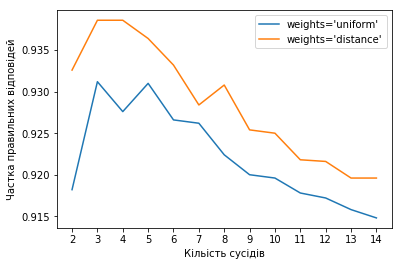

In [11]:
plt.plot(k_range, scores, label='weights=\'uniform\'')
plt.plot(k_range, w_scores, label='weights=\'distance\'')

plt.xticks(k_range)
# plt.yticks(scores)

plt.xlabel('Кільість сусідів')
plt.ylabel('Частка правильних відповідей')
plt.legend()

xmax = max(scores)
xindex = scores.index(xmax)
print(xmax, k_range[xindex])

xmax = max(w_scores)
xindex = w_scores.index(xmax)
print(xmax, k_range[xindex])

In [14]:
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', weights='distance', n_jobs=-1).fit(X_train, y_train)
%time y_pred = knn.predict(X_test)
%time accuracy_score(y_test, y_pred)

CPU times: user 25min 6s, sys: 1.24 s, total: 25min 8s
Wall time: 12min 47s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.26 ms


0.97140000000000004

In [17]:
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Нормалізована матриця помилок")
    else:
        print('Матриця помилок, без нормалізації')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Вірний клас')
    plt.xlabel('Передбачений клас')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

Матриця помилок, без нормалізації
[[ 973    1    1    0    0    1    3    1    0    0]
 [   0 1132    2    0    0    0    1    0    0    0]
 [  10    5  995    2    1    0    0   16    3    0]
 [   0    1    3  974    1   14    1    7    4    5]
 [   1    5    0    0  950    0    4    3    0   19]
 [   4    0    0    9    2  862    7    1    3    4]
 [   4    2    0    0    3    3  946    0    0    0]
 [   0   17    4    0    3    0    0  994    0   10]
 [   5    2    4   14    5   11    4    4  920    5]
 [   3    4    2    7    9    4    1   10    1  968]]


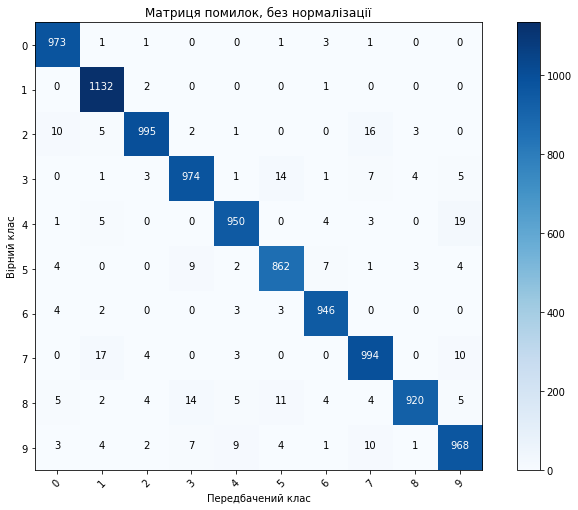

In [18]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                      title='Матриця помилок, без нормалізації')

In [19]:
# save classifier
from sklearn.externals import joblib
joblib.dump(knn, 'app/classifiers/knn.pkl')

['app/classifiers/knn.pkl']